# ERGMs, stock returns, and robustness
Marco Caporaletti, Christian Stoppani \


## Summary of the assignment

This is a practical assignment on Exponential Random Graph Models (ERGMs), analysis and filtering of stock correlations, and network robustness. It consists of the following three tasks.

### Task 1

We work with the World Trade Web network (WTW) with yearly aggregated data from 1992 to 2002. The assignment requires to: 
1. Fit ERGMs, precisely the directed and undirected enhanced configuration models (DECM, UECM) to the the real WTW network for each year
2. Estimate the expected assortativity coefficients (in-in, out-out, in-out, out-in) for the estimated models, by averaging over 30 sampled networks. 
3. Compare the assortativities of the estimated models to the one of the WTW as a function of time.
4. Comment on the results. Notably, if the assortativity of the WTW can be explained by its degree distribution alone, it should be well-modeled by the estimated ERGMs. 

### Task 2

We analyze the stock correlation network defined by correlation of returns of the 97 most capitalized stocks on the NYSE in September 2014. We are provided the correlations of returns at the 1 hour and 1 minute scales, as well as correlation matrices from appropriately fitted Gaussian and 1-factor models. We are required to: 
1. Fit the Marchenko-Pastur law and identify a market mode
2. Filter out the random component of the correlation and compute the degree distribution of the minimum spanning tree (MST) of the resulting network 
3. Plot the obtained degree distributions and compare to the ones of the fitted models provided

### Task 3

We study robustness of different networks structures by simulating random failures and targeted attacks. We do this for two synthetic newtorks (Erdos-Renyi ER and Barabasi Albert BA) and two real-life networks: the European airline network and the Western States US Power Grid network. We are required to: 
1. Generate the synthetic networks and plot the degree distributions of the synthetic and real-life networks
2. Plot the size of the largest connected component as a function of removed edges and nodes under a) random failures b) targeted attacks (by highest degree centrality for nodes and betweenness centrality for edges)
3. Comment on the robustness of the different networks, based on the plots in 2. 


We start by importing the necessary modules and graphs.

In [15]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from NEMtropy import DirectedGraph, UndirectedGraph
from NEMtropy.network_functions import build_adjacency_from_edgelist
from random import choice

#1. ERGMs
years = list(range(1992,2003))
graphs={}
for y in years:
    graphs["wdn_{0}".format(y)] = nx.read_graphml('data/World_Trade_Web/WDN_{0}.txt.graphml'.format(y))

#3. Robustness
airlines = nx.read_gml('data/graph_eu_airlines.gml')
power = nx.read_gml('data/graph_power.gml')

## Task 1: ERGMs

We obtain the four strength assortativities for the trade networks.

In [2]:
in_in_null, in_out_null, out_in_null, out_out_null, undirected_null = [], [], [], [], []

#compute and store the four directed and the undirected strength assortativity on the actual data
for G in tqdm(graphs.keys()):
    in_in_null.append(nx.degree_pearson_correlation_coefficient(graphs[G], 'in','in','weight'))
    in_out_null.append(nx.degree_pearson_correlation_coefficient(graphs[G], 'in','out','weight'))
    out_in_null.append(nx.degree_pearson_correlation_coefficient(graphs[G], 'out','in','weight'))
    out_out_null.append(nx.degree_pearson_correlation_coefficient(graphs[G], 'out','out','weight'))

    undirected_null.append(nx.degree_pearson_correlation_coefficient(graphs[G].to_undirected(),'weight'))

100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


We write two functions to:
1. Fit respectively directed and undirected CMs using the CReMa method.
2. Sample 30 networks and measure compute mean and standard deviation of all strength assortativities.

In [11]:
#define function to compute directed strength assortativities
def DB_analyze(G):
    #get weighted adjancency matrix
    adj = nx.adjacency_matrix(G, weight='weight').toarray()

    #turn into DirectedGraph object to use NEMtropy package
    graph_D = DirectedGraph(adj)
    
    #solve model
    graph_D.solve_tool(model='crema',
             method='newton',
             initial_guess='random',
             adjacency='dcm',
             method_adjacency='newton')
    
    #sample 30 graphs and write to txt as edgelists
    graph_D.ensemble_sampler(30, cpu_n=2, output_dir='./sample_DB/')
    
    in_in_ens = []
    in_out_ens = []
    out_in_ens = []
    out_out_ens = []

    #iterate through sampled graphs
    for i in range(30):
        #load edgelist and build weighted adjacency matrix
        edgelist_ens = np.loadtxt(f"./sample_DB/{i}.txt")
        ens_adj = build_adjacency_from_edgelist(edgelist = edgelist_ens, 
            is_directed = True,
            is_sparse = False,
            is_weighted = True)
        
        #instantiate directed graph
        temp = nx.DiGraph() 
        net = nx.from_numpy_array(ens_adj, create_using=temp)

        #compute directed strength assortativities
        in_in_ens.append(nx.degree_pearson_correlation_coefficient(net, 'in','in','weight'))
        in_out_ens.append(nx.degree_pearson_correlation_coefficient(net, 'in','out','weight'))
        out_in_ens.append(nx.degree_pearson_correlation_coefficient(net, 'out','in','weight'))
        out_out_ens.append(nx.degree_pearson_correlation_coefficient(net, 'out','out','weight'))

    #store and return mean assortativity with standard error
    in_in_samp = [np.average(in_in_ens), np.std(in_in_ens)/np.sqrt(len(in_in_ens))]
    in_out_samp = [np.average(in_out_ens), np.std(in_out_ens)/np.sqrt(len(in_out_ens))]
    out_in_samp = [np.average(out_in_ens), np.std(out_in_ens)/np.sqrt(len(out_in_ens))]
    out_out_samp = [np.average(out_out_ens), np.std(out_out_ens)/np.sqrt(len(out_out_ens))]
    return in_in_samp, in_out_samp, out_in_samp, out_out_samp

#define function to compute undirected strength assortativity     
def UB_analyze(G):
    #obtain adjacency matrix and sum its transpose to obtain symmetrical (undirected) matrix
    adj = nx.to_numpy_array(G)
    adj_sym = adj + np.transpose(adj)
    
    #turn into UndirectedGraph object to use NEMtropy package
    graph_U = UndirectedGraph(adj_sym)
    
    #solve model
    graph_U.solve_tool(model='crema',
             method='newton',
             initial_guess='random',
             adjacency='cm',
             method_adjacency='newton')
    
    #sample 30 graphs and write to txt as edgelists
    graph_U.ensemble_sampler(30, cpu_n=2, output_dir='sample_UB/')
    
    strength_list = []
    
    #iterate through sampled graphs
    for i in range(30):
        #load edgelist and build adjacency matrix
        edgelist_ens = np.loadtxt(f"sample_UB/{i}.txt")
        ens_adj = build_adjacency_from_edgelist(edgelist = edgelist_ens, 
            is_directed = False,
            is_sparse = False,
            is_weighted = True)
        
        #instantiate undirected graph
        net = nx.from_numpy_array(ens_adj)

        #compute undirected strength assortativity
        strength_list.append(nx.degree_pearson_correlation_coefficient(net))
    
    #store and return mean assortativity with standard error
    UB_samp = [np.average(strength_list), np.std(strength_list)/np.sqrt(len(strength_list))]
        
    return UB_samp  

We apply the functions to all 11 graphs provided.

In [4]:
#instantiate empty arrays to store average and error of each strength assortativity
in_in_avg= []
in_in_std= []
in_out_avg= []
in_out_std= []
out_out_avg= []
out_out_std= []
out_in_avg= []
out_in_std= []
UB_avg=[]
UB_std=[]

#iterate through graphs
for G in tqdm(graphs.values()):
    #obtain average and error of sampled directed strength assortativities
    in_in_samp, in_out_samp, out_in_samp, out_out_samp = DB_analyze(G)

    #store in arrays
    in_in_avg.append(in_in_samp[0])
    in_in_std.append(in_in_samp[1])
    in_out_avg.append(in_out_samp[0])
    in_out_std.append(in_out_samp[1])
    out_in_avg.append(out_in_samp[0])
    out_in_std.append(out_in_samp[1])
    out_out_avg.append(out_out_samp[0])
    out_out_std.append(out_out_samp[1])

    #obtain average and error of sampled undirected strength assortativity
    UB_samp = UB_analyze(G)

    #store in arrays
    UB_avg.append(UB_samp[0])
    UB_std.append(UB_samp[1])

  0%|          | 0/11 [00:00<?, ?it/s]C:\Users\stopp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\utils.py:643: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
C:\Users\stopp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\NEMtropy\models_functions.py:1998: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
C:\Users\stopp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\NEMtropy\models_functions.py:1999: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
C:\Users\stopp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8


solution error = 342020746605.4661


C:\Users\stopp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\utils.py:643: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
C:\Users\stopp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\NEMtropy\models_functions.py:197: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
C:\Users\stopp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\NEMtropy\models_functions.py:198: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
C:\Users\stopp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\s


solution error = 564921111653.1743


  9%|▉         | 1/11 [01:53<18:56, 113.68s/it]C:\Users\stopp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\utils.py:643: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",



solution error = 361146467300.88916

solution error = 678236133192.4963


 18%|█▊        | 2/11 [04:03<18:30, 123.42s/it]


solution error = 406674896794.30457

solution error = 796164801548.055


 27%|██▋       | 3/11 [05:59<15:58, 119.78s/it]


solution error = 451961251548.8683

solution error = 902323323517.0221


 36%|███▋      | 4/11 [07:51<13:36, 116.64s/it]


solution error = 471633038923.90344

solution error = 937407416929.579


 45%|████▌     | 5/11 [09:51<11:47, 117.95s/it]


solution error = 1511604523298.4182

solution error = 1000288381945.748


 55%|█████▍    | 6/11 [11:47<09:46, 117.29s/it]


solution error = 537055733323.3235

solution error = 4384082353862.9326


 64%|██████▎   | 7/11 [13:42<07:46, 116.59s/it]


solution error = 560471897714.6166

solution error = 931486036438.6487


 73%|███████▎  | 8/11 [15:46<05:56, 118.86s/it]


solution error = 591465719140.3959

solution error = 1083542426975.7656


 82%|████████▏ | 9/11 [18:04<04:09, 124.99s/it]


solution error = 586248427944.5281

solution error = 1920381463930.8594


 91%|█████████ | 10/11 [20:10<02:05, 125.33s/it]


solution error = 593215172061.1006

solution error = 1497571319808.8584


100%|██████████| 11/11 [22:07<00:00, 120.67s/it]


We plot the data's 5 strength assortativities as well as the means and standard deviations of the sampled ERGMs' strength assortativities for each year (graph) in the data.

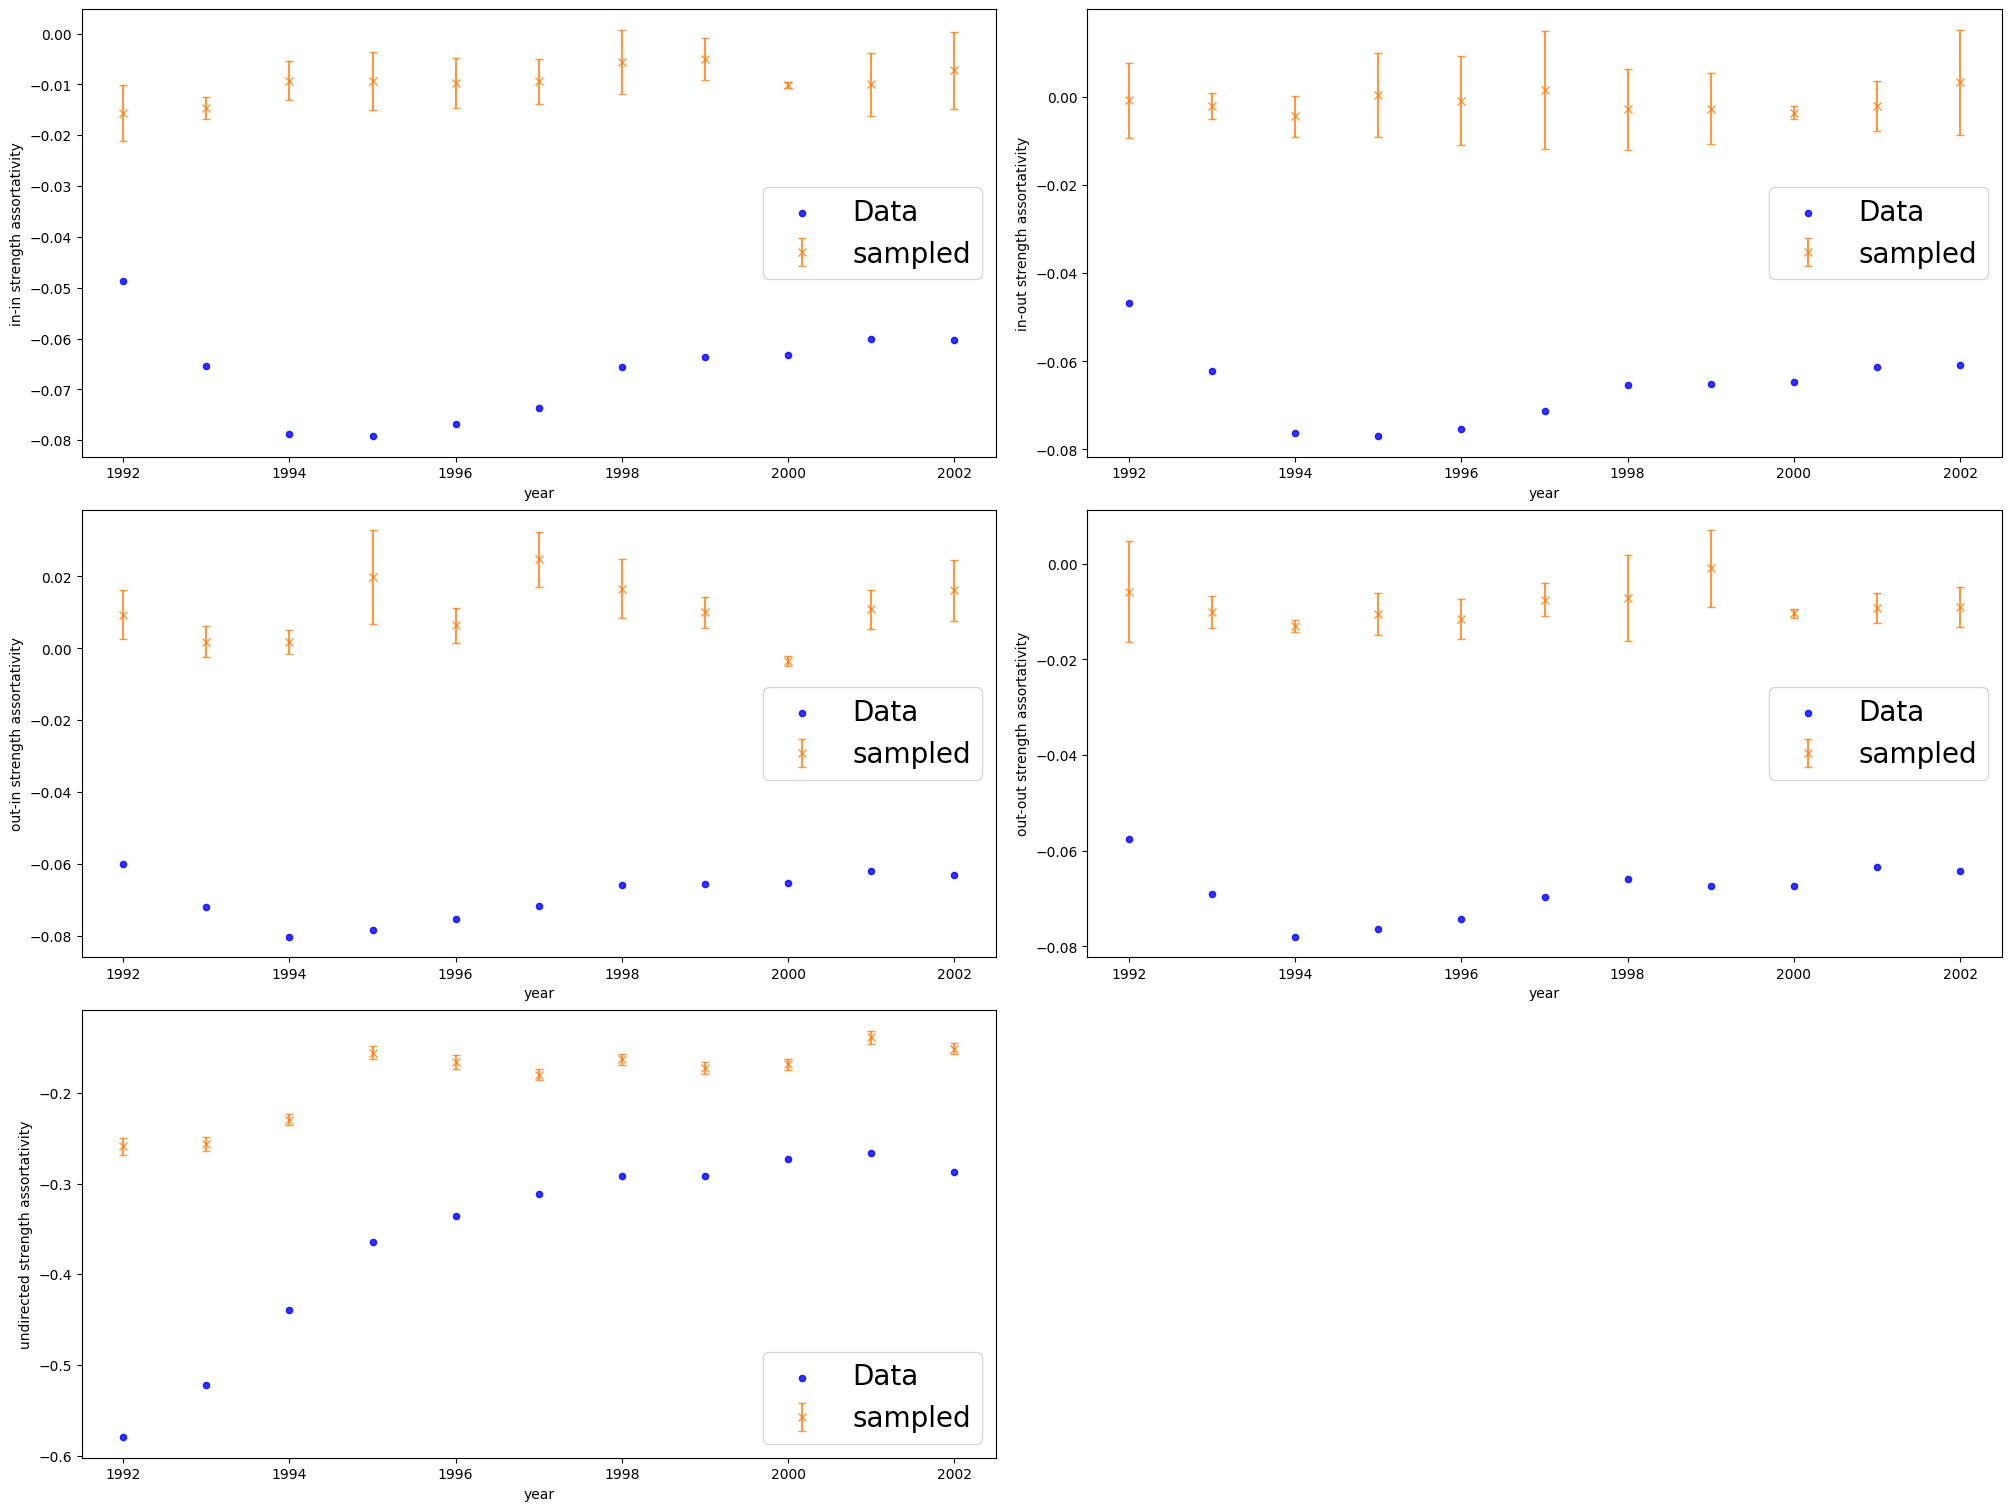

In [14]:
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(20,15))

#in-in strength assortativity
axs[0,0].scatter(years, in_in_null, label="Data", s=20, alpha=0.8,color='blue')
axs[0,0].errorbar([],[])
axs[0,0].errorbar(years, in_in_avg, yerr=in_in_std, alpha=0.8,
                  fmt = 'x',capsize=3, label='sampled')
axs[0,0].set_xlabel("year")
axs[0,0].set_ylabel("in-in strength assortativity")
legend = axs[0,0].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

#in-out strength assortativity
axs[0,1].scatter(years, in_out_null, label="Data", s=20, alpha=0.8,color='blue')
axs[0,1].errorbar([],[])
axs[0,1].errorbar(years, in_out_avg, yerr=in_out_std, alpha=0.8,
                  fmt = 'x',capsize=3, label='sampled')
axs[0,1].set_xlabel("year")
axs[0,1].set_ylabel("in-out strength assortativity")
legend = axs[0,1].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

#out-in strength assortativity
axs[1,0].scatter(years, out_in_null, label="Data", s=20, alpha=0.8,color='blue')
axs[1,0].errorbar([],[])
axs[1,0].errorbar(years, out_in_avg, yerr=out_in_std, alpha=0.8,
                  fmt = 'x',capsize=3, label='sampled')
axs[1,0].set_xlabel("year")
axs[1,0].set_ylabel("out-in strength assortativity")
legend = axs[1,0].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

#out-out strength assortativity
axs[1,1].scatter(years, out_out_null, label="Data", s=20, alpha=0.8,color='blue')
axs[1,1].errorbar([],[])
axs[1,1].errorbar(years, out_out_avg, yerr=out_out_std, alpha=0.8,
                  fmt = 'x',capsize=3, label='sampled')
axs[1,1].set_xlabel("year")
axs[1,1].set_ylabel("out-out strength assortativity")
legend = axs[1,1].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

#undirected strength assortativity
axs[2,0].scatter(years, undirected_null, label="Data", s=20, alpha=0.8,color='blue')
axs[2,0].errorbar([],[])
axs[2,0].errorbar(years, UB_avg, yerr=UB_std, alpha=0.8,
                  fmt = 'x',capsize=3, label='sampled')
axs[2,0].set_xlabel("year")
axs[2,0].set_ylabel("undirected strength assortativity")
legend = axs[2,0].legend(loc='best', frameon=True, shadow=False, fontsize=20,ncol=1)

axs[-1, -1].axis('off');

The graphs depict worldwide trade, with countries as nodes and directed trade flows as edges. In this context, strength assortativity assesses the degree to which countries trade with other countries with similar trade flows. As the plots show evidence of disassortativity, we can say that nations tend to trade with other nations with differing trade patterns.
 
For the four directed strength assortativities, the computed values are lower than the respective averages for the sampled ERGMs, meaning that the values cannot by explained by the networks' degree distributions alone. Instead, the assortativities are likely due to the nature of trade itself, which sees countries of different sizes exchange different goods and services according to their respective specializations and needs, rather than exclusivey deal with comparable counterparts. The strikingly similar results obtained for all four assortativities suggest countries tend to exhibit similar trading patterns in terms of both imports and exports.

The undirected assortativity differs from the directed ones, as it is significantly lower, and increasing over the period. The increased disassortativity of the undirected network, compared to the directed one, means that the heterogeneity among trading partners is even higher when looking at the magnitude of trade between countries, rather than directional flows. However, the positive slope of the plot shows that undirected disassortativity decreased over time, that is, countries are increasingly trading with similar counterparts in terms of total trade volumes.

## Task 2: Stock correlations

In [218]:
# obtain the name of the stocks 
stocks = []
with open('data/NYSE/stocknames.txt') as f:
    for line in f:
        stocks.append(line.rstrip())

# put them into a dictionary
stocks_d = {i:v for i,v in enumerate(stocks)}

# Load the correlation matrices
# real correlation matrices
cormat_1h = np.load('data/NYSE/cormat_1h.npy')
cormat_1m = np.load('data/NYSE/cormat_1m.npy')

# correlation martices of the fitted gaussian model
cormat_gaussian_1h = np.load('data/NYSE/cormat_gaussian_1h.npy')
cormat_gaussian_1m = np.load('data/NYSE/cormat_gaussian_1m.npy')

# correlation matrices of the fitted 1-factor model
cormat_1f_1h = np.load('data/NYSE/cormat_onefactor_1h.npy')
cormat_1f_1m = np.load('data/NYSE/cormat_onefactor_1m.npy')

N = len(cormat_1h[:,0]) # both arrays have the same length N = 97

### 2.1. Visual detection of market mode
First, we define the Marchenko-Pastur law.

In [219]:
def MPlaw(lam, Q, sigma):
    lam_max = sigma**2 * ( 1 + Q**(-1) + 2 * Q**(-1/2) )
    lam_min = sigma**2 * ( 1 + Q**(-1) - 2 * Q**(-1/2) )
    lam = lam[(lam >= lam_min) & (lam <= lam_max)]
    return lam_min, lam_max, lam, Q * ( lam_max - lam )**(1/2) * ( lam - lam_min )**(1/2) / ( 2 * np.pi * sigma**2 * lam)

Next, we perform a visual inspection of the eigenvalues vs the theoretical distribution for the noise.

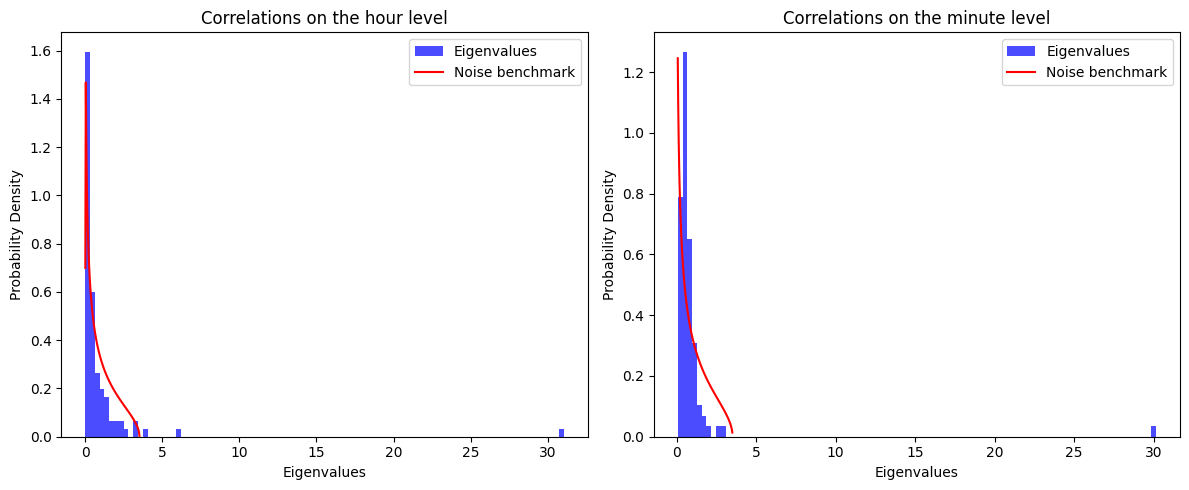

In [220]:
# Compute empirical Q and sigma for MP law

t_h = 6*21  #6 trading hours/day times 21 trading days in Sep 2014
t_m = t_h # In principle, t_m should be roughly t_h*60. But I found that the fit of the curve to the eigenvalue histogram 
# is best when I take t_m approximately equal to t_h.
Q_h = t_h / N
Q_m = t_m / N
s_h = np.trace(cormat_1h)/N  # empirical standard deviation of the original returns matrix (turns out to be normalized)
s_m = np.trace(cormat_1m)/N  # empirical standard deviation of the original returns matrix (turns out to be normalized)

# Diagonalize correlation matrices

hour_eval, hour_evec = np.linalg.eig(cormat_1h)
min_eval, min_evec = np.linalg.eig(cormat_1m)

# Plot eigenvalue distribution against theoretical benchmark

sorted_eval_h = np.sort(hour_eval)
sorted_eval_m = np.sort(min_eval)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for the correlation at the hour timescale
axes[0].hist(sorted_eval_h, bins=100, density=True, alpha=0.7, color='blue', label='Eigenvalues')

x_values_h = np.linspace(min(sorted_eval_h), max(sorted_eval_h), 1000)
_, _, x_values_h, y_values_h = MPlaw(x_values_h, Q_h,s_h)

axes[0].plot(x_values_h, y_values_h, color='red', label='Noise benchmark')
axes[0].set_title('Correlations on the hour level')
axes[0].set_xlabel('Eigenvalues')
axes[0].set_ylabel('Probability Density')
axes[0].legend()

# Plot for the correlation at the minute timescale
axes[1].hist(sorted_eval_m, bins=100, density=True, alpha=0.7, color='blue', label='Eigenvalues')

x_values_m = np.linspace(min(sorted_eval_m), max(sorted_eval_m), 1000)
_, _, x_values_m, y_values_m = MPlaw(x_values_m, Q_m,s_m)

axes[1].plot(x_values_m, y_values_m, color='red', label='Noise benchmark')
axes[1].set_title('Correlations on the minute level')
axes[1].set_xlabel('Eigenvalues')
axes[1].set_ylabel('Probability Density')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

The market mode is clearly visible on the left of both histograms, around the value 30.
### 2.2. Minimum Spanning Tree
First we de-noise the correlation matrices as in the lecture slides.

In [221]:
def denoise(M, Q, sigma):
    e, v = np.linalg.eig(M)
    _, lam_max, _, _ = MPlaw(M, Q, sigma)
    N = len(e)
    N_noise = np.sum(e < lam_max)
    e[e < lam_max] = (N - np.sum(e[e >= lam_max]))/N_noise  ## We choose the constant as suggested by Nicolò on Teams, in an answer to Xiaomeng Gu
    return v @ np.diag(e) @ np.linalg.inv(v)

cormat_1h_denoised = denoise(cormat_1h, Q_h, s_h)  
cormat_1m_denoised = denoise(cormat_1m, Q_m, s_m)  

In [222]:
# Define function to compute degree distribution of denoised matrix

def MST_degree(corr):
    # some of the correlation (just few) are larger than one. 
    # This makes sense to me as I don't see an obvious reason why the denoising procedure should preserve that fact that every entry is <= 1.
    # However it is a problem for computing the distance so we cap them.
    corr[corr >= 1] = 1 
    dist = np.sqrt(2 * (1 - corr))
    net = nx.from_numpy_array(dist)
    MST = nx.minimum_spanning_tree(net)
    return dict(MST.degree())

In [223]:
# Obtain 5 stocks with highest degree
deg_1h = MST_degree(cormat_1h_denoised)
deg_1m = MST_degree(cormat_1m_denoised)
print('The 5 stocks with highest degree are:\n\nHour timescale: ')
print([stocks[i] for i in np.asarray(sorted(deg_1h.items(), key=lambda x:x[1], reverse=True)[0:5])[:,0]])
print ('\n\nMinute timescale:')
print([stocks[i] for i in np.asarray(sorted(deg_1m.items(), key=lambda x:x[1], reverse=True)[0:5])[:,0]])

The 5 stocks with highest degree are:

Hour timescale: 
['HON', 'UNP', 'COP', 'DIS', 'XOM']


Minute timescale:
['HON', 'AAPL', 'ABBV', 'ABT', 'ACN']


### 2.3. Degree distribution

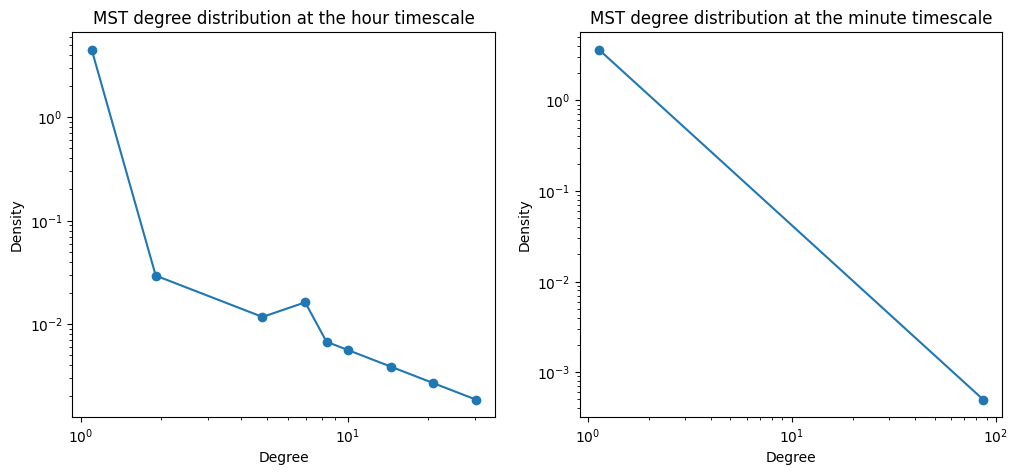

In [224]:
deg1h_array = np.array(list(deg_1h.values()))
bins_1h  = np.logspace(np.log10(max(min(deg1h_array),1)),np.log10(max(deg1h_array) +1), 20 ) 

deg1m_array = np.array(list(deg_1m.values()))
bins_1m  = np.logspace(np.log10(max(min(deg1m_array),1)),np.log10(max(deg1m_array) +1), 20 ) 

# Calculate the histogram
hist_1h, bin_edges_1h = np.histogram(deg1h_array, bins=bins_1h, density=True)
hist_1m, bin_edges_1m = np.histogram(deg1m_array, bins=bins_1m, density=True)

# Calculate the bin centers
bin_centers_1h = (bin_edges_1h[:-1] + bin_edges_1h[1:]) / 2
bin_centers_1m = (bin_edges_1m[:-1] + bin_edges_1m[1:]) / 2

# Create subplots using fig, axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histograms using points and lines
axes[0].plot(bin_centers_1h[hist_1h>0], hist_1h[hist_1h>0], marker = 'o')
axes[1].plot(bin_centers_1m[hist_1m>0], hist_1m[hist_1m>0], marker = 'o')

# Settings
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Density')
axes[0].set_title('MST degree distribution at the hour timescale')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Density')
axes[1].set_title('MST degree distribution at the minute timescale')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

# Show the plot

plt.show()

### 2.4. Comparisons

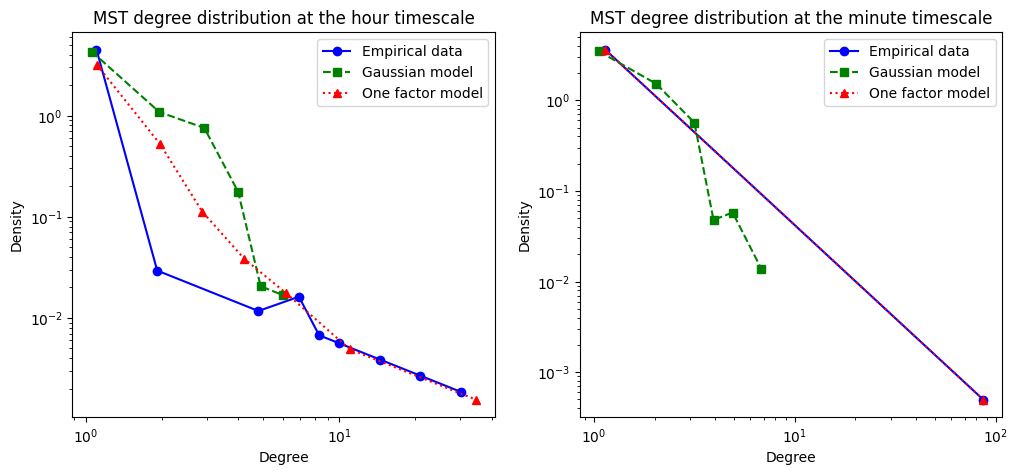

In [233]:
# Preparation of gaussian and one-factor degree distributions (these do not need to be denoised)
deg1h_gaussian = np.array(list(MST_degree(cormat_gaussian_1h).values()))
deg1m_gaussian = np.array(list(MST_degree(cormat_gaussian_1m).values()))
deg1h_1f = np.array(list(MST_degree(cormat_1f_1h).values()))
deg1m_1f = np.array(list(MST_degree(cormat_1f_1m).values()))

bins_1h_gaussian  = np.logspace(np.log10(max(min(deg1h_gaussian),1)),np.log10(max(deg1h_gaussian) +1), 20 ) 
bins_1m_gaussian  = np.logspace(np.log10(max(min(deg1m_gaussian),1)),np.log10(max(deg1m_gaussian) +1), 20 ) 
bins_1h_1f  = np.logspace(np.log10(max(min(deg1h_1f),1)),np.log10(max(deg1h_1f) +1), 20 ) 
bins_1m_1f  = np.logspace(np.log10(max(min(deg1m_1f),1)),np.log10(max(deg1m_1f) +1), 20 ) 

# Calculate the histogram
hist_1h_gaussian, bin_edges_1h_gaussian = np.histogram(deg1h_gaussian, bins=bins_1h_gaussian, density=True)
hist_1m_gaussian, bin_edges_1m_gaussian = np.histogram(deg1m_gaussian, bins=bins_1m_gaussian, density=True)
hist_1h_1f, bin_edges_1h_1f = np.histogram(deg1h_1f, bins=bins_1h_1f, density=True)
hist_1m_1f, bin_edges_1m_1f = np.histogram(deg1m_1f, bins=bins_1m_1f, density=True)

# Calculate the bin centers
bin_centers_1h_gaussian = (bin_edges_1h_gaussian[:-1] + bin_edges_1h_gaussian[1:]) / 2
bin_centers_1m_gaussian = (bin_edges_1m_gaussian[:-1] + bin_edges_1m_gaussian[1:]) / 2
bin_centers_1h_1f = (bin_edges_1h_1f[:-1] + bin_edges_1h_1f[1:]) / 2
bin_centers_1m_1f = (bin_edges_1m_1f[:-1] + bin_edges_1m_1f[1:]) / 2

# Now we creat the plots

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histograms using points and lines
axes[0].plot(bin_centers_1h[hist_1h>0], hist_1h[hist_1h>0], label='Empirical data', marker='o', linestyle='-', color='blue')
axes[0].plot(bin_centers_1h_gaussian[hist_1h_gaussian>0], hist_1h_gaussian[hist_1h_gaussian>0], label='Gaussian model', marker='s', linestyle='--', color='green')
axes[0].plot(bin_centers_1h_1f[hist_1h_1f>0], hist_1h_1f[hist_1h_1f>0], label='One factor model', marker='^', linestyle=':', color='red')

axes[1].plot(bin_centers_1m[hist_1m>0], hist_1m[hist_1m>0], label='Empirical data', marker='o', linestyle='-', color='blue')
axes[1].plot(bin_centers_1m_gaussian[hist_1m_gaussian>0], hist_1m_gaussian[hist_1m_gaussian>0], label='Gaussian model', marker='s', linestyle='--', color='green')
axes[1].plot(bin_centers_1m_1f[hist_1m_1f>0], hist_1m_1f[hist_1m_1f>0], label='One factor model', marker='^', linestyle=':', color='red')

# Settings
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Density')
axes[0].set_title('MST degree distribution at the hour timescale')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Density')
axes[1].set_title('MST degree distribution at the minute timescale')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

# Sow legends
axes[0].legend()
axes[1].legend()

# Show the plot
plt.show()

The Gaussian model does not accurately reproduce the data on the hour nor the minute timescale: it does not have heavy enough tails. The one-factor model works better in this case, however we expect it to also fail to describe the tails of the MST degree distribution if more stocks are considered.

## Task 3: Robustness

In [208]:
#generate synthetic Erdos-Renyi and Barabasi-Albert graphs using Networkx
ER_graph_1 = nx.gnm_random_graph(1000, 500)
ER_graph_4 = nx.gnm_random_graph(1000, 2000)
BA_graph_2 = nx.barabasi_albert_graph(1000,2)
BA_graph_4 = nx.barabasi_albert_graph(1000,4)

In [209]:
def plot_deg_dist(G, n_bins):
    #obtain degree distribution from graph G
    deg = np.array(list(dict(G.degree()).values()))
    bins = np.logspace(np.log10(min(deg)+1), np.log10(max(deg)+1), n_bins)
    hist, bin_edges = np.histogram(deg, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

    return [bin_centers, hist]


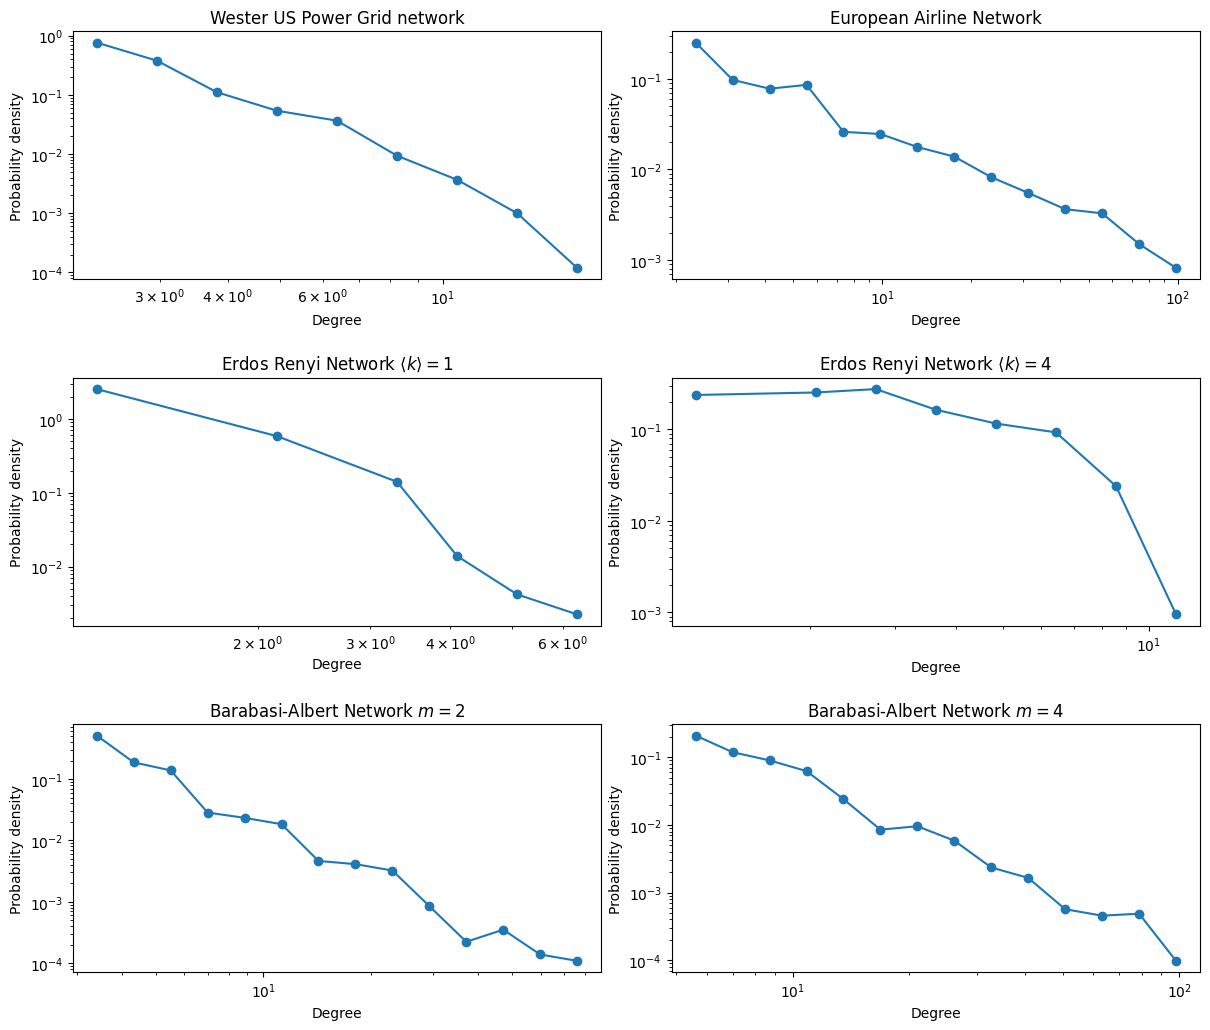

In [244]:
#compute degree distributions for all graphs
ER_1_dist = plot_deg_dist(ER_graph_1, 10)
ER_4_dist = plot_deg_dist(ER_graph_4, 10)
BA_2_dist = plot_deg_dist(BA_graph_2, 15)
BA_4_dist = plot_deg_dist(BA_graph_4, 15)
airlines_dist = plot_deg_dist(airlines, 15)
power_dist = plot_deg_dist(power, 10)

#plot setup
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.tight_layout(h_pad=5, w_pad=2)


#plot each graph individually
axes[0,0].set_xlabel('Degree')
axes[0,0].set_ylabel('Probability density')
axes[0,0].plot(power_dist[0][power_dist[1]>0], power_dist[1][power_dist[1]>0], marker='o')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Wester US Power Grid network')

axes[0,1].set_xlabel('Degree')
axes[0,1].set_ylabel('Probability density')
axes[0,1].plot(airlines_dist[0][airlines_dist[1]>0], airlines_dist[1][airlines_dist[1]>0], marker='o')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].set_title('European Airline Network')

axes[1,0].set_xlabel('Degree')
axes[1,0].set_ylabel('Probability density')
axes[1,0].plot(ER_1_dist[0][ER_1_dist[1]>0], ER_1_dist[1][ER_1_dist[1]>0], marker='o')
axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Erdos Renyi Network $ \\langle k \\rangle = 1$')

axes[1,1].set_xlabel('Degree')
axes[1,1].set_ylabel('Probability density')
axes[1,1].plot(ER_4_dist[0][ER_4_dist[1]>0], ER_4_dist[1][ER_4_dist[1]>0], marker='o')
axes[1,1].set_xscale('log')
axes[1,1].set_yscale('log')
axes[1,1].set_title('Erdos Renyi Network $ \\langle k \\rangle = 4$')

axes[2,0].set_xlabel('Degree')
axes[2,0].set_ylabel('Probability density')
axes[2,0].plot(BA_2_dist[0][BA_2_dist[1]>0], BA_2_dist[1][BA_2_dist[1]>0], marker='o')
axes[2,0].set_xscale('log')
axes[2,0].set_yscale('log')
axes[2,0].set_title('Barabasi-Albert Network $ m = 2$')

axes[2,1].set_xlabel('Degree')
axes[2,1].set_ylabel('Probability density')
axes[2,1].plot(BA_4_dist[0][BA_4_dist[1]>0], BA_4_dist[1][BA_4_dist[1]>0], marker='o')
axes[2,1].set_xscale('log')
axes[2,1].set_yscale('log')
axes[2,1].set_title('Barabasi-Albert Network $ m = 4$');

In [242]:
def attack_graph(G = nx.Graph(), title = str, tqdm_s = False):
    #instantiate empty arrays for the three attacks
    random, targeted_deg, targeted_bet = [], [], []
    #instantiate three graphs as copies of G
    random_G, targeted_deg_G, targeted_bet_G = G.copy(), G.copy(), G.copy()

    #get list of nodes
    nodes = list(range(G.number_of_nodes()))
  
    #status indicator set up 
    if tqdm_s:
        pbar = tqdm(total=len(nodes))

    #instantiate variable for number of nodes
    nodes_nr = 1

    while nodes_nr!=0:
        #calculate largest connected component for random attack graph
        random.append(len(max(nx.connected_components(random_G), key=len)))
        #remove random node
        random_G.remove_node(choice(list(random_G.nodes())))

        #calculate largest connected component for degree centrality attack graph
        targeted_deg.append(len(max(nx.connected_components(targeted_deg_G), key=len)))
        #compute degree centrality
        deg_cent = nx.degree_centrality(targeted_deg_G)
        #remove node with highest value
        targeted_deg_G.remove_node(max(deg_cent, key=deg_cent.get))

        #calculate largest connected component for betweenness centrality attack graph
        targeted_bet.append(len(max(nx.connected_components(targeted_bet_G), key=len)))
        #compute betweenness centrality
        bet_cent = nx.betweenness_centrality(targeted_bet_G)
        #remove node with highest value
        targeted_bet_G.remove_node(max(bet_cent, key=bet_cent.get))
        
        #update number of nodes
        nodes_nr = len(random_G.nodes())

        #update status indicator
        if tqdm_s:
            pbar.update(1)
    
    #close status indicator
    if tqdm_s:
        pbar.close()

    #plot evolution of lcc against number of nodes removed    
    plt.figure(figsize=(12, 8))
    plt.xlabel('Number of nodes removed')
    plt.ylabel('Largest connected component size')
    plt.plot(nodes, random, label='Random attack')
    plt.plot(nodes, targeted_deg, label='Targeted, degree centrality')
    plt.plot(nodes, targeted_bet, label='Targeted, betweenness centrality')
    plt.legend()
    plt.title(title)

    


100%|██████████| 4941/4941 [16:02:34<00:00, 11.69s/it]   


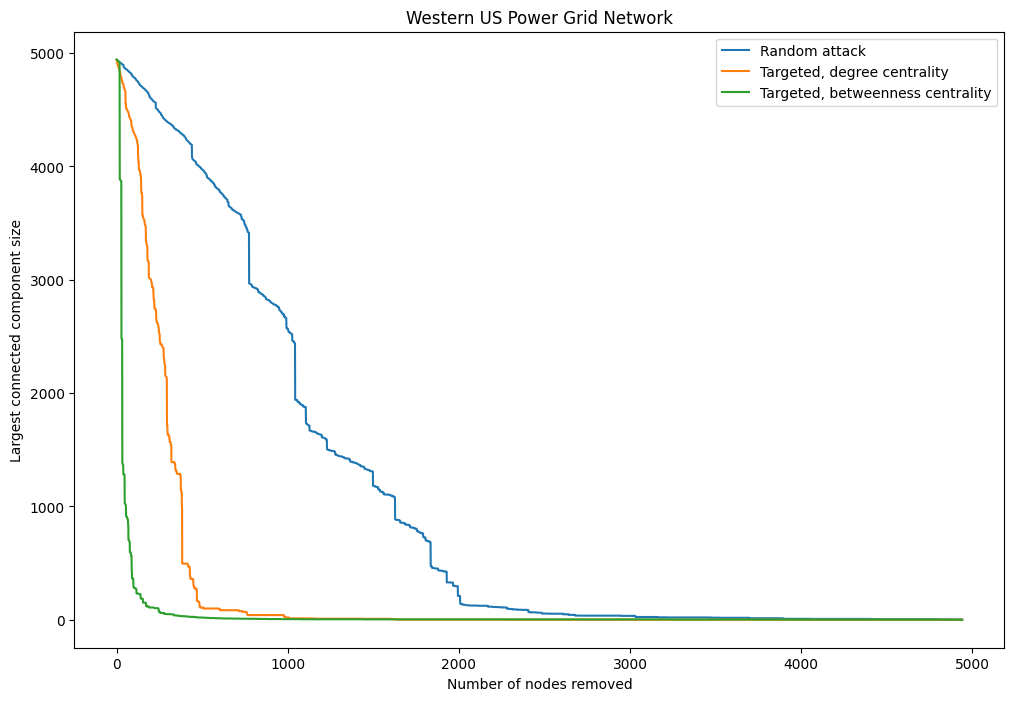

In [217]:
attack_graph(power, 'Western US Power Grid Network', True)

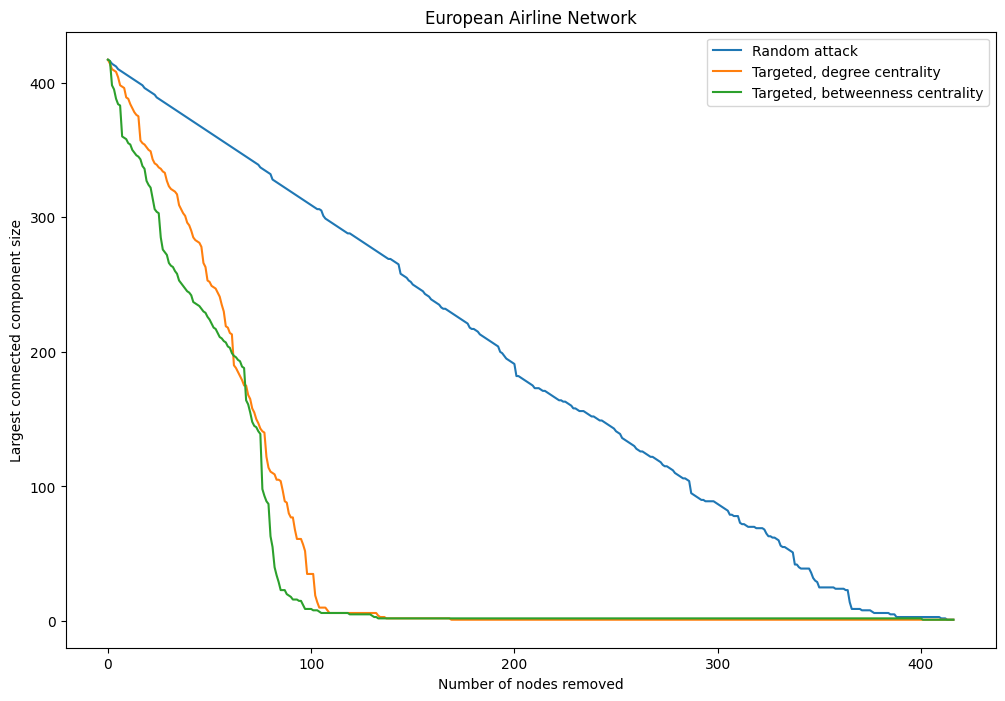

In [131]:
attack_graph(airlines, 'European Airline Network')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:44<00:00,  9.56it/s]


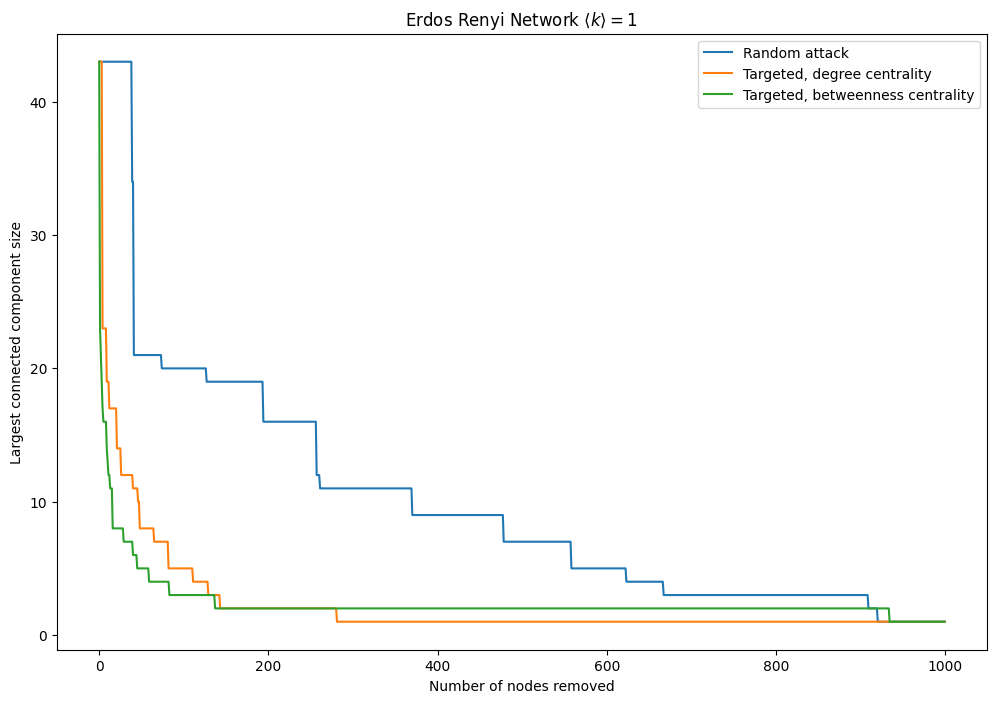

In [236]:
attack_graph(ER_graph_1, 'Erdos Renyi Network $ \\langle k \\rangle = 1$', True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:31<00:00,  2.56it/s]


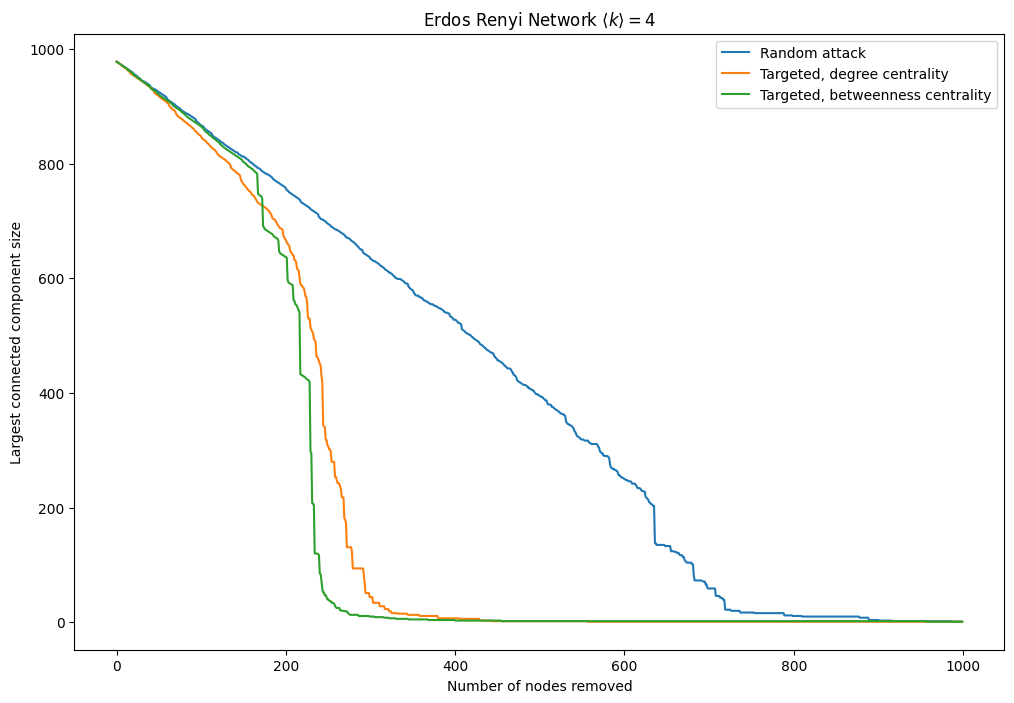

In [237]:
attack_graph(ER_graph_4, 'Erdos Renyi Network $\\langle k \\rangle = 4$', True)

100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s]


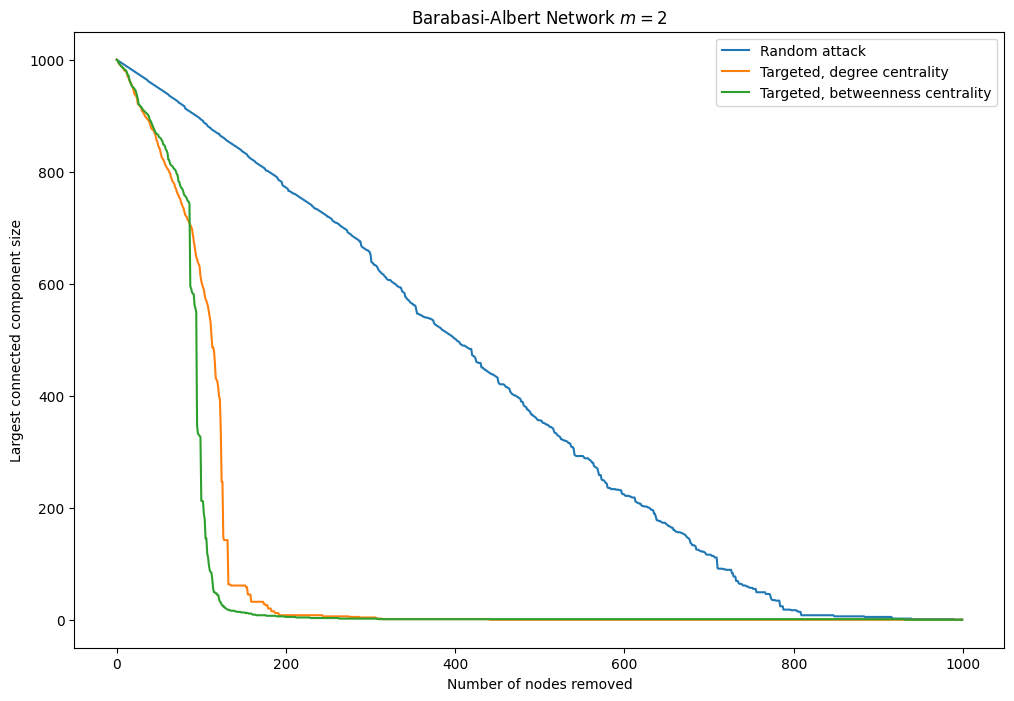

In [238]:
attack_graph(BA_graph_2, 'Barabasi-Albert Network $m = 2$', True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [15:30<00:00,  1.08it/s]   


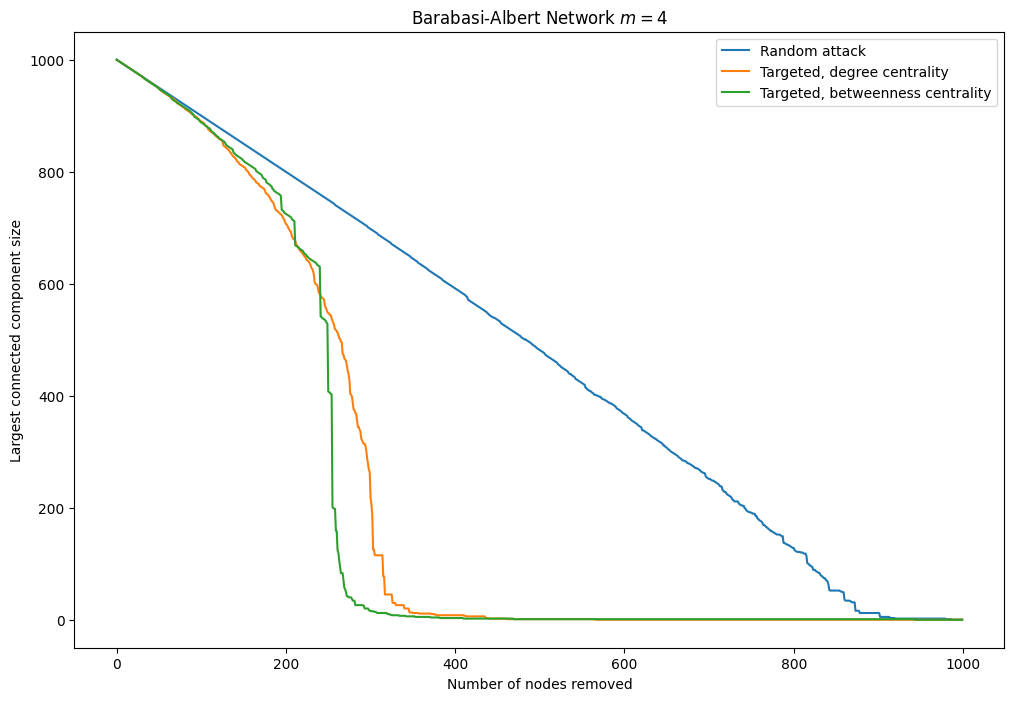

In [239]:
attack_graph(BA_graph_4, 'Barabasi-Albert Network $m = 4$', True)

Looking at the degree distributions of the two real networks, the airline network is the one that more clearly displays a scale-free distribution. According to the theory of percolation on graphs that we saw in class, this should grant the network a higher resilience to random node failures, as is evident from the first two plots: the giant component in the airline network does not break down for any number of (random) node removals, while the one of the power grid network disappears at some finite fraction of nodes removed, between 0 and 1. 

Concerning the synthetic models, we expect the scale-free BA networks to be more resilient to failures, but more vulnerable to targeted attacks, compared to random (ER) networks. This is also clearly visible in the plots above:

1. In the first plot we do not see a giant component at all: the value $\langle k \rangle = 1$ is the critical point in the phase transition for the ER graph, and at this value the giant component indeed does not emerge. 

2. The ER graph with average degree of 4 does instead have a giant component, as is to be expected from the theory. It is comparable with the BA graph with $m=2$, because the average degree of the latter is also roughly equal to 4. As predicted by the theory, the giant component of the ER network appears to break down when roughly $1000*(1-1/\langle k\rangle)=750$ nodes are removed at random. The BA network (third figure) is more resilient to random failures due to its scale-freeness, and the giant components only breaks down when all nodes are removed. On the flip side, when attacks are targeted by centrality, the ER graph, due to its randomness, is a bit more resilient than the BA one. This is due to the fact that the hubs, that grant its resilience to the scale-free network when nodes are removed randomly, also represent weaknesses that are exploited by the targeted attacks. 

3. Finally, the BA model with $m=4$ has twice as many links as the previous to graphs (and thus twice as large average degree), and it is thus more reselient to failures and attacks.